In [1]:
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0ml4o_nc because the default path (/home/dforeman/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import numpy as np
import scipy.stats
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.io import fits
from astropy.io import ascii

import kepler
import corner

In [3]:
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"
get_ipython().magic('config InlineBackend.figure_format = "retina"')

In [71]:
from astropy.table import Table

In [72]:
Table.read("/data/rv_uncertainty_grid.fits")

ValueError: No table found

In [4]:
with fits.open("/data/rv_uncertainty_grid.fits") as f:
    hdr = f[0].header
    mu = f[1].data
    sigma = f[2].data
    
color_bins = np.linspace(hdr["MIN_COL"], hdr["MAX_COL"], hdr["NUM_COL"] + 1)
mag_bins = np.linspace(hdr["MIN_MAG"], hdr["MAX_MAG"], hdr["NUM_MAG"] + 1)
ivar = 1.0 / sigma ** 2

ln_sigma_model = gaussian_filter(np.mean(mu, axis=-1), (1, 0.8))

interp = RegularGridInterpolator(
    [0.5 * (mag_bins[1:] + mag_bins[:-1]), 0.5 * (color_bins[1:] + color_bins[:-1])],
    ln_sigma_model,
    bounds_error=False,
    fill_value=None
)

In [5]:
with fits.open("/data/kepler_dr2_1arcsec.fits") as f:
    kic = f[1].data

In [6]:
ebs = ascii.read("kepler-ebs.csv", format='csv', header_start=7)
# data = data[data["period"] > 10]

In [68]:
# kepid = 4245897
kepid = 10020423
eb = ebs[ebs["#KIC"] == kepid][0]
target = kic[kic["kepid"] == kepid][0]

In [69]:
target["radial_velocity_error"]

nan

In [55]:
np.random.seed(723)
n_samp = 1000000

# Simulate transit times by sampling target_num_transit samples from the scanning law
t = np.random.uniform(0, 668, (int(target["rv_nb_transits"]), n_samp))

eps = 0.02 * np.random.randn(n_samp)

# Sample many parameters from the prior
period = np.abs(eb["period"] + eb["period_err"] * np.random.randn(n_samp))
phase = np.random.uniform(-np.pi, np.pi, n_samp)
log_semiamp = np.random.uniform(np.log(0.1), np.log(100.0), n_samp)
ecc = scipy.stats.beta(0.867, 3.03).rvs(n_samp)
omega = np.random.uniform(-np.pi, np.pi, n_samp)

# Compute the Keplerian model
cosw = np.cos(omega)
sinw = np.sin(omega)
M = 2 * np.pi * t / period + phase[None, :]
_, cosf, sinf = kepler.kepler(M, ecc[None, :] + np.zeros_like(M))
mod = np.exp(log_semiamp[None, :]) * (cosw[None, :] * (ecc[None, :] + cosf) - sinw[None, :] * sinf)

In [56]:
sigma = np.exp(interp(np.array([target["phot_g_mean_mag"], target["bp_rp"]]).T))

In [57]:
sigma

array([1.06373998])

In [58]:
lam = np.sum((mod - np.mean(mod, axis=0)[None, :])**2, axis=0)

In [59]:
target_num_transit = int(target["rv_nb_transits"])
target_sample_variance = 2 * target_num_transit * (float(target["radial_velocity_error"]) ** 2 - 0.11 ** 2) / np.pi
log_sigma = interp([float(target["phot_g_mean_mag"]), float(target["bp_rp"])])
ivar = np.exp(-2 * (log_sigma + eps))
target_lam = lam * ivar
ncx2 = scipy.stats.ncx2(df=target_num_transit, nc=target_lam)
log_weight = ncx2.logpdf((target_num_transit - 1) * target_sample_variance * ivar)

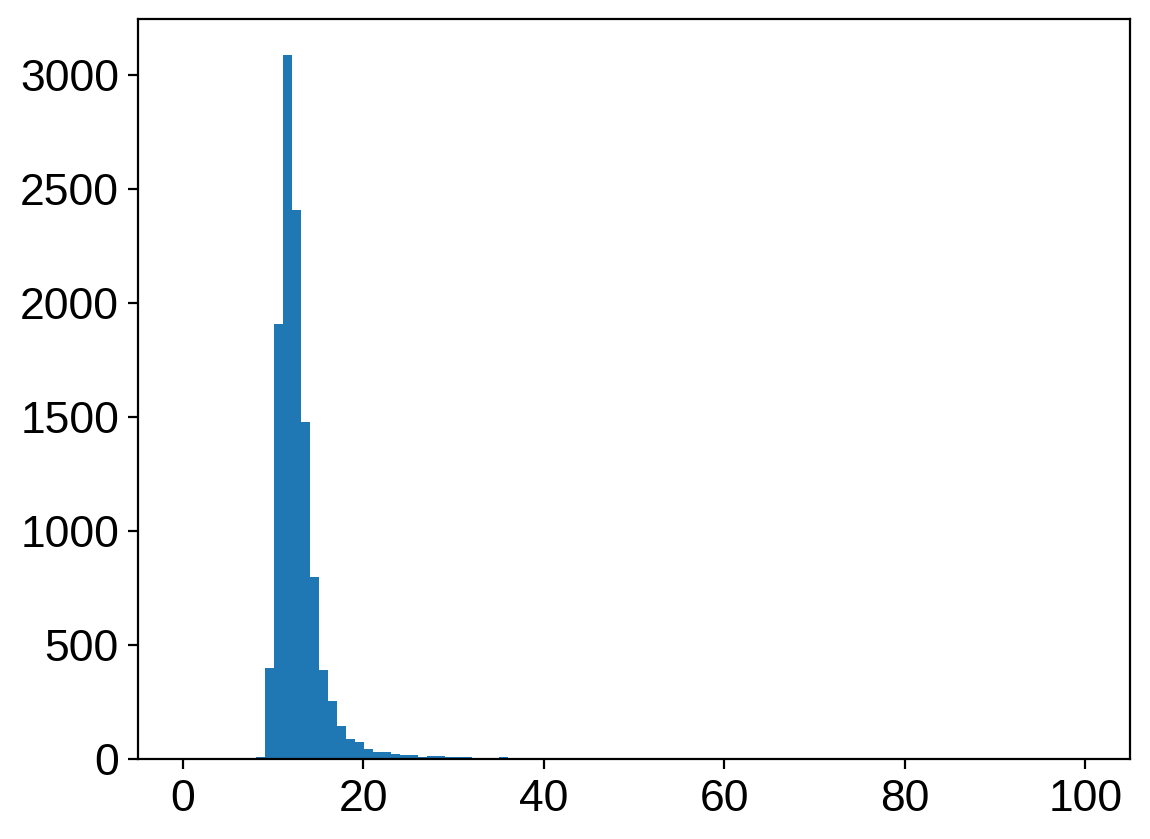

In [60]:
plt.hist(np.exp(log_semiamp), 100, weights=np.exp(log_weight - log_weight.max()));

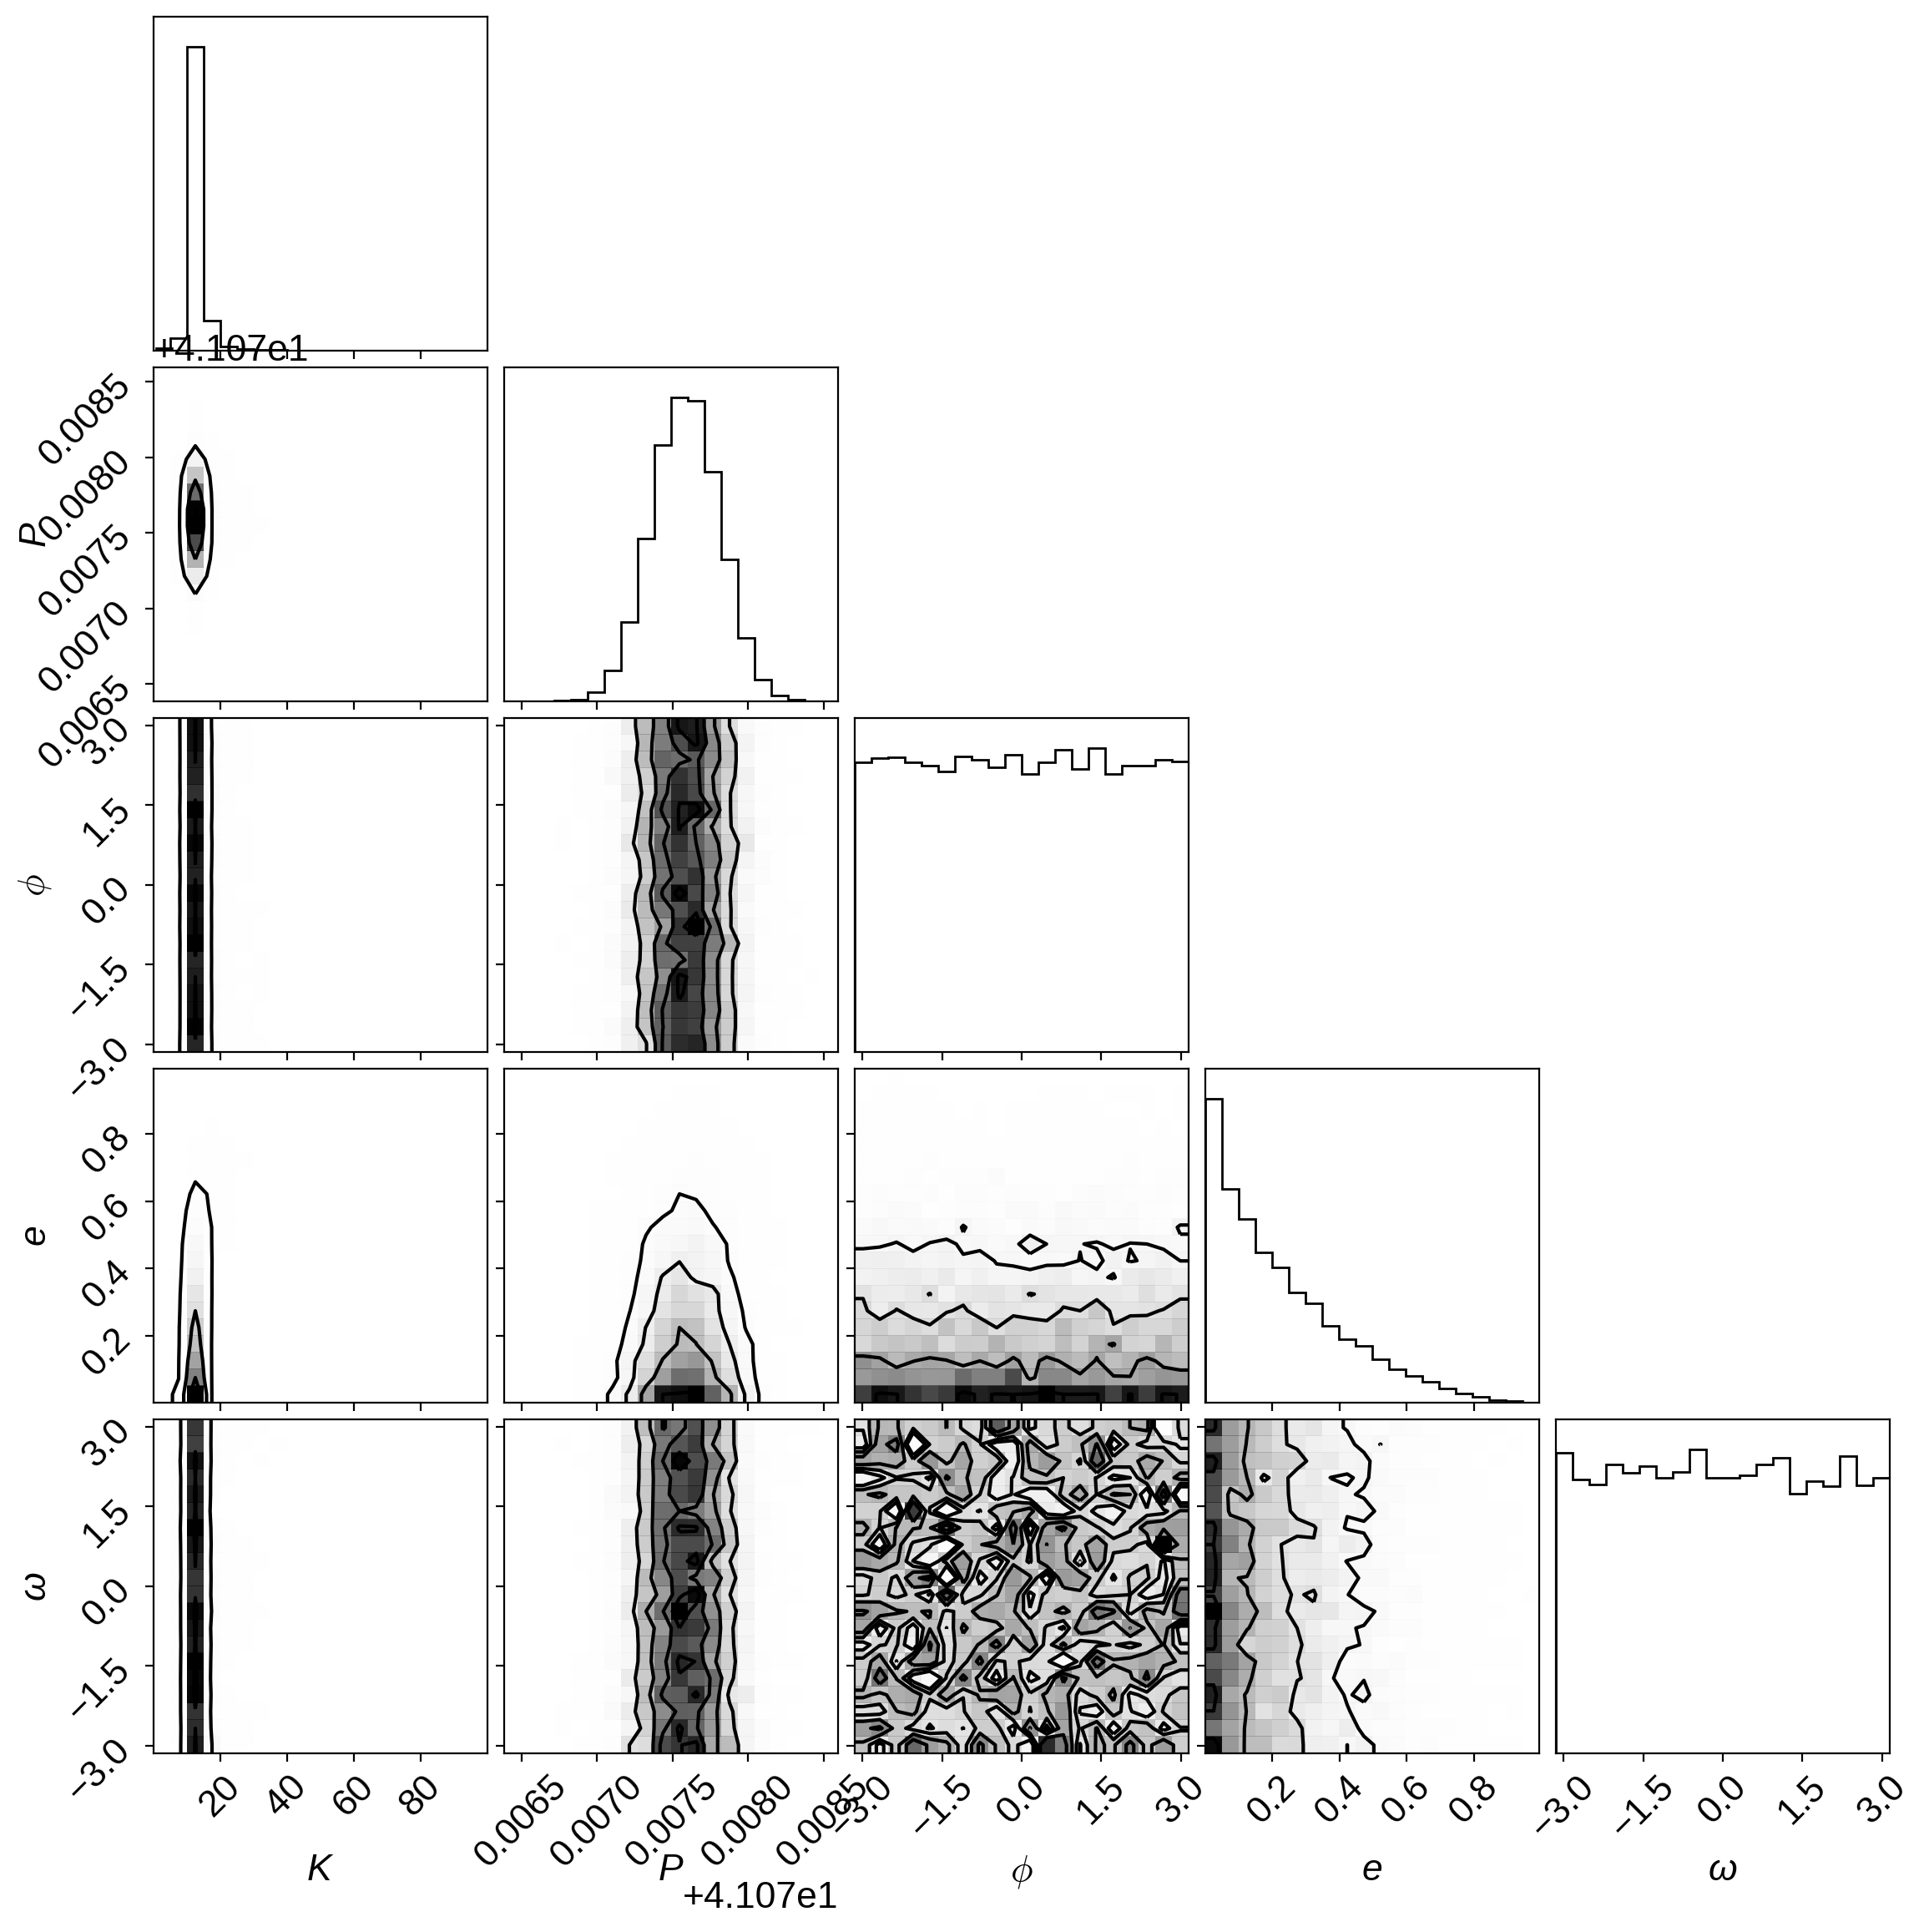

In [61]:
corner.corner(
    np.stack((np.exp(log_semiamp), period, phase, ecc, omega)).T,
    weights=np.exp(log_weight - log_weight.max()),
    plot_datapoints=False,
    labels=["$K$", "$P$", r"$\phi$", "$e$", r"$\omega$"]
);

In [41]:
q = corner.quantile(np.exp(log_semiamp), [0.16, 0.5, 0.84], weights=np.exp(log_weight - log_weight.max()))
print(q[1], np.diff(q), np.diff(q) / q[1])

25.48061705779276 [ 5.51344761 17.0979495 ] [0.2163781  0.67101787]


In [23]:
ebsp = ebs[(ebs["period"] > 100)]

for i in ebsp["#KIC"]:
    if not np.any(np.isfinite(kic[kic["kepid"] == i]["radial_velocity_error"])):
        continue
    print(i, kic[kic["kepid"] == i]["radial_velocity_error"], kic[kic["kepid"] == i]["rv_nb_transits"])

9904059 [5.53115433] [5]
2444348 [1.37142854] [3]
6678383 [2.28655287] [3]
4473933 [9.21103975] [8]
4247991 [1.21533514] [10]
11392618 [1.01206188] [9]
8491745 [3.95265309] [11]
3442054 [4.33530366] [7]
10001167 [7.64875025] [9]
7768447 [4.71433009] [13]
9028474 [1.76687394] [8]
6933781 [0.40823481] [11]
10614012 [7.9741797] [6]
11044668 [11.08053641] [4]
8210370 [3.12870634] [7]
4255422 [6.41140347] [9]
9540226 [8.56571712] [3]
7037405 [7.94047282] [7]
6850665 [3.8651588] [7]
9970396 [8.65066727] [4]
5039392 [6.07879965] [9]
8052474 [5.30606176] [10]
8703129 [0.30500057] [5]
4054905 [4.77142612] [9]
7431665 [4.05934742] [6]
9153621 [7.49435466] [7]
5005618 [7.92057095] [7]
5866138 [5.73645586] [5]
4663623 [3.76598114] [8]
6307083 [0.56283639] [12]
2306756 [1.54197265] [7]
8410637 [7.37054487] [8]
6757558 [1.5642237] [12]
9151763 [2.09828955] [12]
5652983 [1.74368475] [3]
6268648 [1.55238597] [8]
8288404 [3.33357624] [9]
7293054 [5.01999482] [2]
5640750 [3.46559733] [6]
8054233 [2.1899

In [65]:
eb = data[data["#KIC"] == 4245897][0]
eb

#KIC,period,period_err,bjd0,bjd0_err,morph,GLon,GLat,kmag,Teff,SC,col11
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,int64
4245897,11.2578219,3.43e-05,54973.788825,0.167341,0.51,70.1255,14.2779,12.538,6595.0,True,--
